# Setup

In [244]:
# Install packages
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [245]:
# Imports
import sklearn as sk
import opendatasets as od
import pandas as pd
import numpy as np
import nltk
import csv
import json
import math
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, log_loss, classification_report

In [246]:
# Downloads

# Dataset
# {"username":"noahagonzo","key":"b7e4d1aedc1148c648f8fcef1ab58905"}
od.download("https://www.kaggle.com/datasets/rashikrahmanpritom/heart-attack-analysis-prediction-dataset")

# stopwords
nltk.download('stopwords')

Skipping, found downloaded files in "./heart-attack-analysis-prediction-dataset" (use force=True to force download)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [247]:
# Setup constants
STOPWORDS = list(set(stopwords.words('english')))
vectorizer = TfidfVectorizer(stop_words = STOPWORDS, binary=True)

## Import Text Data

In [248]:
# Import training data
df = pd.read_csv('heart-attack-analysis-prediction-dataset/heart.csv', header=0, encoding='utf-8')
# 30 from Sigmund Freud, 30 from Jane Austen, 30 from Mark Twain, and 30 from Maya Angelou
df.shape
print(df.head())

   age  sex  cp  trtbps  chol  fbs  restecg  thalachh  exng  oldpeak  slp  \
0   63    1   3     145   233    1        0       150     0      2.3    0   
1   37    1   2     130   250    0        1       187     0      3.5    0   
2   41    0   1     130   204    0        0       172     0      1.4    2   
3   56    1   1     120   236    0        1       178     0      0.8    2   
4   57    0   0     120   354    0        1       163     1      0.6    2   

   caa  thall  output  
0    0      1       1  
1    0      2       1  
2    0      2       1  
3    0      2       1  
4    0      2       1  


# Distribution of Target Class

1    165
0    138
Name: output, dtype: int64


array([[<Axes: title={'center': 'output'}>]], dtype=object)

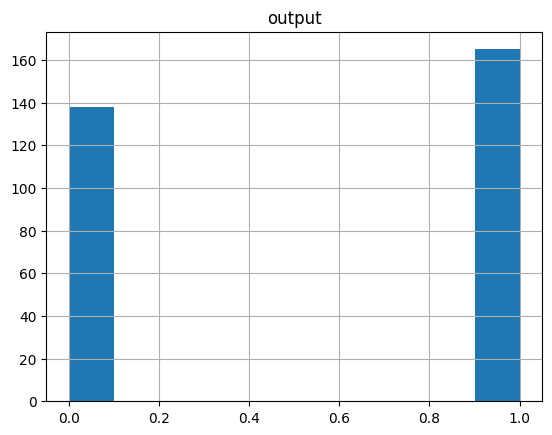

In [249]:
# Distribution of the target classes
print(df.output.value_counts())
df.hist(column="output")

<Axes: >

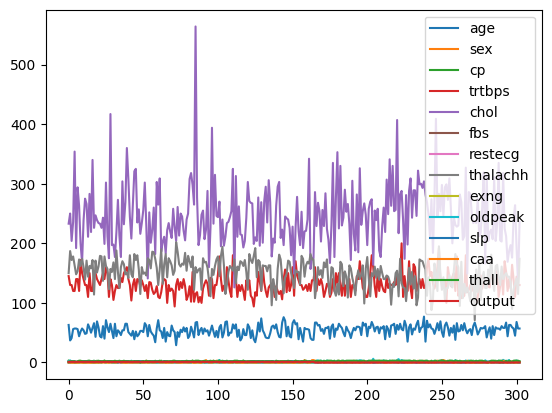

In [250]:
df.plot()

array([[<Axes: title={'center': 'age'}>, <Axes: title={'center': 'sex'}>,
        <Axes: title={'center': 'cp'}>,
        <Axes: title={'center': 'trtbps'}>],
       [<Axes: title={'center': 'chol'}>,
        <Axes: title={'center': 'fbs'}>,
        <Axes: title={'center': 'restecg'}>,
        <Axes: title={'center': 'thalachh'}>],
       [<Axes: title={'center': 'exng'}>,
        <Axes: title={'center': 'oldpeak'}>,
        <Axes: title={'center': 'slp'}>, <Axes: title={'center': 'caa'}>],
       [<Axes: title={'center': 'thall'}>,
        <Axes: title={'center': 'output'}>, <Axes: >, <Axes: >]],
      dtype=object)

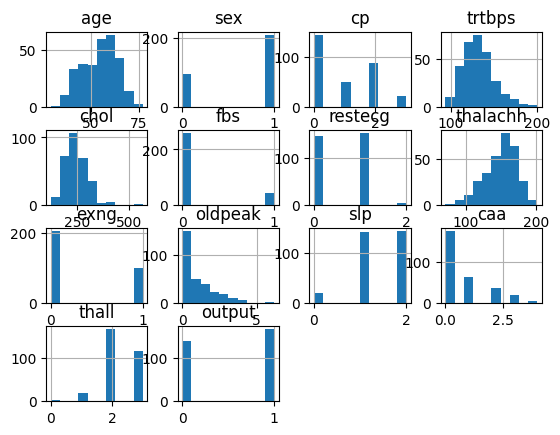

In [251]:
df.hist()

## Preprocess text


In [252]:
# old
#df['quote'].replace('[\d][\d]+', ' num ', regex=True, inplace=True)
#df['quote'].replace('[!@#*][!@#*]+', ' punct ', regex=True, inplace=True)
#df['quote'].replace('[A-Z][A-Z]+', ' caps ', regex=True, inplace=True)

## Divide train/test

In [253]:
# Get everything except output
X = df.iloc[:, :13]
X

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3


In [254]:
# Get the values
X  = X.values
X

array([[63.,  1.,  3., ...,  0.,  0.,  1.],
       [37.,  1.,  2., ...,  0.,  0.,  2.],
       [41.,  0.,  1., ...,  2.,  0.,  2.],
       ...,
       [68.,  1.,  0., ...,  1.,  2.,  3.],
       [57.,  1.,  0., ...,  1.,  1.,  3.],
       [57.,  0.,  1., ...,  1.,  1.,  2.]])

In [255]:
# Get target
y = df.iloc[:, -1]
y

0      1
1      1
2      1
3      1
4      1
      ..
298    0
299    0
300    0
301    0
302    0
Name: output, Length: 303, dtype: int64

In [256]:
y = y.values
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [257]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8, random_state=23423423)

# Sequential Model

## First iteration

In [258]:
# Build model
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(13,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [259]:
# compile
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [260]:
X_train.shape

(242, 13)

In [261]:
# create a validation set
x_val = X_train[:220]
partial_X_train = X_train[220:]

y_val = y_train[:220]
partial_y_train = y_train[220:]

In [262]:
# train
history = model.fit(partial_X_train, partial_y_train, epochs=100, batch_size=64,validation_data=(x_val, y_val))

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 15.8266 - accuracy: 0.4545 - val_loss: 12.2001 - val_accuracy: 0.4545
Epoch 2/100
1/1 [==============================] - 0s 184ms/step - loss: 11.0897 - accuracy: 0.4545 - val_loss: 8.7796 - val_accuracy: 0.4500
Epoch 3/100
1/1 [==============================] - 0s 295ms/step - loss: 7.7581 - accuracy: 0.4545 - val_loss: 6.1203 - val_accuracy: 0.4318
Epoch 4/100
1/1 [==============================] - 0s 194ms/step - loss: 5.0603 - accuracy: 0.4545 - val_loss: 4.2747 - val_accuracy: 0.4136
Epoch 5/100
1/1 [==============================] - 0s 248ms/step - loss: 3.1913 - accuracy: 0.4545 - val_loss: 3.4741 - val_accuracy: 0.3864
Epoch 6/100
1/1 [==============================] - 0s 238ms/step - loss: 2.6566 - accuracy: 0.4545 - val_loss: 3.2242 - val_accuracy: 0.3773
Epoch 7/100
1/1 [==============================] - 0s 230ms/step - loss: 2.5194 - accuracy: 0.4545 - val_loss: 3.0767 - val_accuracy: 0.3773
Epoch 8/100
1

In [263]:
# sklearn evaluation
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

2/2 [==============================] - 0s 33ms/step
              precision    recall  f1-score   support

           0       0.62      0.28      0.38        29
           1       0.56      0.84      0.68        32

    accuracy                           0.57        61
   macro avg       0.59      0.56      0.53        61
weighted avg       0.59      0.57      0.54        61



In [264]:
# use tf evaluation method

losses_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
losses_and_metrics

1/1 [==============================] - 0s 159ms/step - loss: 0.8740 - accuracy: 0.5738


[0.8740105628967285, 0.5737704634666443]

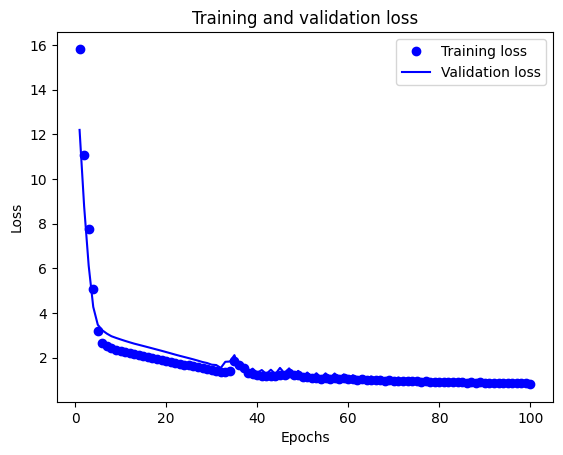

In [265]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

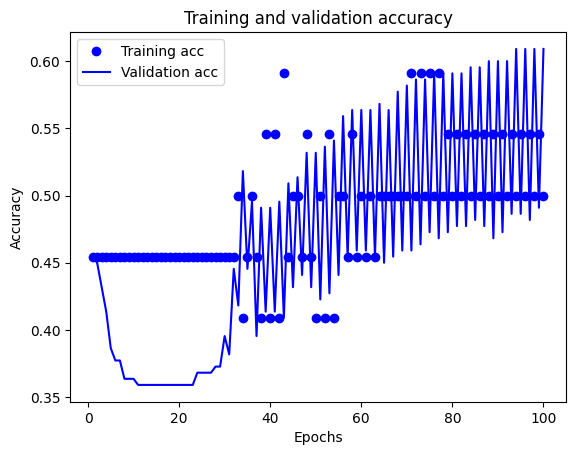

In [266]:
# plot the training and validation accuracy

plt.clf()   # clear

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

both the training loss and validation loss decrease steadily with more training. 

Looking at the accuracy plot, the training accuracy jumps between multiple values. I am not sure how to resolve this, but it eventually jumps to a higher values with more epochs. The valdiation accuracy does steadily increase with more epochs, however. 

It would be ideal to continue training

## Second iteration

In [267]:
# train
history = model.fit(partial_X_train, partial_y_train, epochs=300, batch_size=64,validation_data=(x_val, y_val))

Epoch 1/300
1/1 [==============================] - 0s 408ms/step - loss: 0.8543 - accuracy: 0.5455 - val_loss: 0.9320 - val_accuracy: 0.4955
Epoch 2/300
1/1 [==============================] - 0s 124ms/step - loss: 0.8343 - accuracy: 0.5000 - val_loss: 0.7734 - val_accuracy: 0.6091
Epoch 3/300
1/1 [==============================] - 0s 152ms/step - loss: 0.8493 - accuracy: 0.5455 - val_loss: 0.9247 - val_accuracy: 0.4955
Epoch 4/300
1/1 [==============================] - 0s 123ms/step - loss: 0.8293 - accuracy: 0.5000 - val_loss: 0.7671 - val_accuracy: 0.6091
Epoch 5/300
1/1 [==============================] - 0s 115ms/step - loss: 0.8445 - accuracy: 0.5455 - val_loss: 0.9179 - val_accuracy: 0.4955
Epoch 6/300
1/1 [==============================] - 0s 171ms/step - loss: 0.8245 - accuracy: 0.5000 - val_loss: 0.7611 - val_accuracy: 0.6091
Epoch 7/300
1/1 [==============================] - 0s 82ms/step - loss: 0.8399 - accuracy: 0.5455 - val_loss: 0.9113 - val_accuracy: 0.4909
Epoch 8/300
1/

In [268]:
# sklearn evaluation
pred = model.predict(X_test)
pred = [1.0 if p>= 0.5 else 0.0 for p in pred]
print(classification_report(y_test, pred))

2/2 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       0.80      0.41      0.55        29
           1       0.63      0.91      0.74        32

    accuracy                           0.67        61
   macro avg       0.72      0.66      0.64        61
weighted avg       0.71      0.67      0.65        61



In [269]:
# use tf evaluation method

losses_and_metrics = model.evaluate(X_test, y_test, batch_size=128)
losses_and_metrics

1/1 [==============================] - 0s 56ms/step - loss: 0.7268 - accuracy: 0.6721


[0.7267655730247498, 0.6721311211585999]

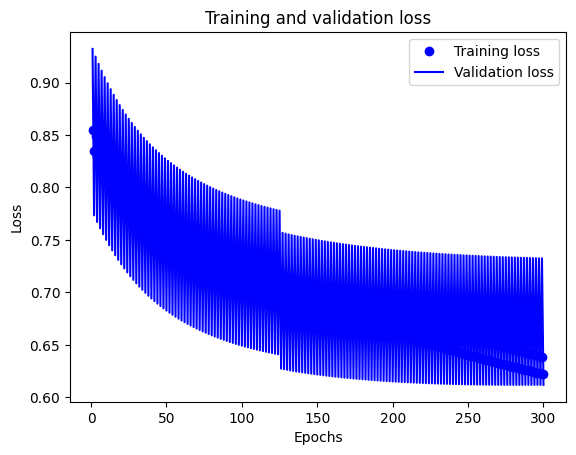

In [270]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

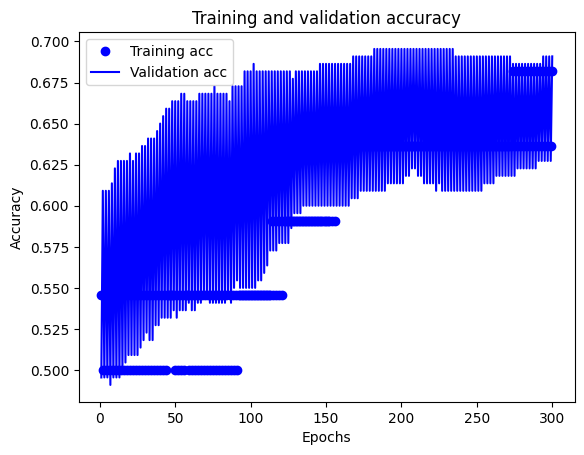

In [271]:
# plot the training and validation accuracy

plt.clf()   # clear

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Accuracy levels out after 200 epochs. The large number of epochs is needed because of the large number of features.